<div style="margin: 0 auto 30px; height: 60px; border: 2px solid gray; border-radius: 6px;">
  <div style="float: left;"><img src="img/epfl.png" /></div>
  <div style="float: right; margin: 20px 30px 0; font-size: 10pt; font-weight: bold;"><a href="https://moodle.epfl.ch/course/view.php?id=18253">COM202 - Signal Processing</a></div>
</div>
<div style="clear: both; font-size: 30pt; font-weight: bold; color: #483D8B;">
    Lab 5: Dual-Tone Multi-Frequency (DTMF) dialing
</div>

In this notebook we will build a DTMF encoder and implement a decoder based on the Fourier transform.

In [184]:
# first our usual bookkeeping
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import IPython

In [185]:
plt.rcParams["figure.figsize"] = (14,4)

# Introduction

<div style="float: right; margin: 10px;"><img src="img/phone.jpg" width="250"></div>

When you use the keypad of an analog phone such as the one on the right, the sequence of dialed digits is transmitted to the equipment in the phone company's switches in the form of _dial tones_.  This was in the day before all-digital networks and cell phones were the norm, but the method is still used today for in-call option selection ("press 4 to talk to customer service"...).


DTMF signaling is the way analog phones send the number dialed by a user over to the central phone office. 

The encoding mechanism is rather clever: the phone's keypad is arranged in a $4\times 3$ grid and each button is associated with *two* frequencies according to this table:


|            | **1209 Hz** | **1336 Hz** | **1477 Hz** |
|------------|:-----------:|:-----------:|:-----------:|
| **697 Hz** |      1      |      2      |      3      |
| **770 Hz** |      4      |      5      |      6      |
| **852 Hz** |      7      |      8      |      9      |
| **941 Hz** |      *      |      0      |      #      |


The frequencies in the table have been chosen so that they are "coprime"; in other words, no frequency is a rational multiple of any other, which reduces the probability of erroneously detecting the received signals due to interference. When a button is pressed, the two corresponding frequencies are generated simultaneously and sent over the line. For instance, if the digit '1' is pressed, the generated signal will be:

$$
    x(t) = \sin(2\pi\cdot 1209\cdot t) + \sin(2\pi\cdot697\cdot t)
$$

## Discrete-time implementation

DTMF was developed in the late 1950s and the first commercial DTMF phones hit the market in the 1960s. At the time, the system was implemented using analog hardware and the various frequencies were generated by a set of individual electronic oscillators.

Obviously in this notebook we can only use discrete-time signals, so we need to establish an invertible mapping between the real-world frequencies of the DTMF standard and their digital counterparts. This is relatively straightforward even without any formal knowledge of sampling and interpolation since all the signals involved are pure sinusoids.

### Digital to analog 

As we have seen in class, a digital-to-analog converter like the soundcard in your PC can "play" a discrete-time signal by outputting the samples at a constant rate $F_s$, measured in samples per second; this rate is the "clock" of the soundcard and it is referred to as the _sampling rate_ or sampling _frequency_ of the system. 

When a soundcard with sampling rate $F_s$ plays a pure discrete-time sinusoid with angular frequency $\omega_0$, that is, a sequence of the form $x[n] = \cos(\omega_0 n)$, the output is a continuous-time sinusoid of the form $\cos(2\pi f_0 t)$ with frequency

$$
    f_0 = \frac{\omega_0}{2\pi}F_s.
$$

What this means is that the pitch you hear when a discrete-time sinusoid is played by a soundcard depends _both_ on the frequency of the discrete-time sinusoid _and_ on the sampling rate of the soundcard, and the latter is usually a user-definable parameter. Here is an example: listen to how the pitch changes when the _same_ discrete-time sinusoid is played by the soundcard at different sampling rates: 

In [186]:
w0 = 2 * np.pi * 0.05
x = np.sin(w0 * np.arange(0, 8000))

In [187]:
# let's play the sequence using 8000 samples per second
IPython.display.Audio(x, rate=8000)

In [188]:
# now let's play the same sequence but now using 16000 samples per second
IPython.display.Audio(x, rate=16000)

In [189]:
# and now using 4000 samples per second
IPython.display.Audio(x, rate=4000)

### Analog to digital

When used to record audio, a PC soundcard works as an analog to digital converter and _measures_ its analog input signal at a fixed rate $F_s$ to produce $F_s$ discrete-time samples every second. 

Again, if the input is a simple sinusoid of the form $\sin(2\pi f_0 t)$ the resulting discrete-time sequence will be 

$$
    x[n] = \sin(\omega_0 n) \qquad \text{with} \qquad \omega_0 = 2\pi\frac{f_0}{F_s}.
$$

The only requirement here is that the sampling frequency $F_s$ must be larger than _twice_ the frequency of the input sinusoid, i.e. $F_s > 2f_0$. 

### Exercise: aliasing


What happens if the input to the soundcard is a sinusoid with frequency $f_0 = 1.6F_s$? 

The sound isn't unique

In [190]:
Fs  = 8000
f0 = 1.6*Fs
w0 = 2 * np.pi *f0
x = np.sin(w0 * np.arange(0, Fs))
IPython.display.Audio(x, rate=Fs)


### Exercise: minimum sampling frequency

What is the minimum sampling frequency $F_s$ if we want to implement a digital DTMF decoder?

That $F_s > 2f_0$ so $F_s$ > 1477 Hz since 1477 is the highest frequence of the DTMF

In the rest of the notebook, we will use $F_s = 8000$ since not all soundcards today offer a choice of lower sampling rates.

In [191]:
Fs = 8000

# The encoder

Before designing a decoder, let's implement a DTMF encoder according to the official specifications. We already know the frequencies associated to each key; the requirements on timings are:

 * each tone should be at least 65ms long
 * tones corresponding to successive digits should be separated by a silent gap of at least 65ms

### Exercise: a DTMF encoder

Complete the function below so that it returns the DTMF encoding of a series of keys passed as a string. For your convenience, the dictionary containing the DTMF frequencies is already provided, as well as the durations (in seconds) of the tones and the silence gap. (We choose the latter larger than the lower bound  65ms to distinguish them more easily.)

In [192]:
def DTMF_encode(digits: str, Fs=8000) -> np.ndarray: 
    TONE_SEC, SPACE_SEC = 0.2, 0.1
    DTMF_FREQS = {
        '1': (697, 1209), '2': (697, 1336), '3': (697, 1477),
        '4': (770, 1209), '5': (770, 1336), '6': (770, 1477),
        '7': (852, 1209), '8': (852, 1336), '9': (852, 1477),
        '*': (941, 1209), '0': (941, 1336), '#': (941, 1477),        
    }
    
    # create a list of tones
    tones = []
    for digit in digits:
        tones.append(DTMF_FREQS[digit])

    # create a list of samples for each tone
    samples = []
    for freq1, freq2 in tones:
        t = np.arange(0, TONE_SEC, 1/Fs)
        x = np.sin(2*np.pi*freq1*t) + np.sin(2*np.pi*freq2*t)
        samples.append(x)
        samples.append(np.zeros(int(SPACE_SEC*Fs)))

    # concatenate all samples
    return np.concatenate(samples)

Let's test it and evaluate it "by ear":

In [193]:
x = DTMF_encode('123##45', Fs=Fs)
IPython.display.Audio(x, rate=Fs)

# The decoder

Now let's start thinking about the decoder. We will use the following strategy:

 * we will split the signal into individual key presses by looking at the position of the silent gaps
 * we will compute the DFT of each segment
 * we will search for the peaks in the DFT magnitude to recover the frequencies in each tone

## Signal segmentation

In order to split the signal, the idea is to find the points where the signal goes from silence to a tone. Since silence corresponds to samples with an amplitude of zero, the idea is to detect the parts of the signal where the energy is below a certain threshold. We will use a short **analysis window** to process the signal one chunk at a time, compute the power (i.e. the average energy) of the signal for each chunk, and use the resulting values to mark each chunk as belonging to a silent gap or to a tone.

Let's see how we can do that; let's look at the raw data first:

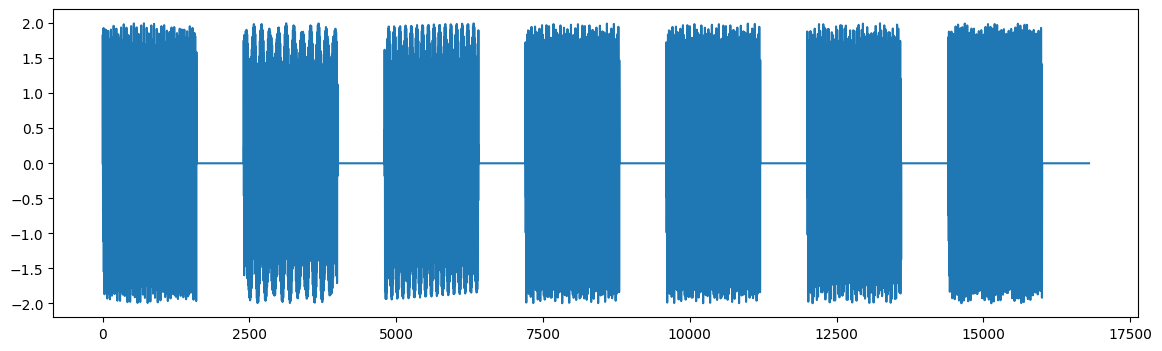

In [194]:
plt.plot(x);

It seems clear that the high and low energy regions of the signal should be relatively easy to find. However, we don't really know yet what value to use for the threshold. Let's first see what happens if we compute the power of the signal over 10ms chunks. 

### Exercise: local power values

In the cell below, complete the code for a function that computes the _average_ energy (that is, the power) of a signal over successive chunks of fixed length. To do so:
 - reshape the signal into a two-dimensional array so that each row contains a number of samples corresponding to the size of the analysis window 
 - compute the each chunk's power as the average of the squares of the samples
 - return two arrays:
   - the first array should contain the sample number corresponding to the beginning of each chunk
   - the second array should contain the power of the corresponding chunk

In [195]:
def local_power(x: np.ndarray, chunk_len_ms: int, Fs=8000) -> tuple[np.ndarray, np.ndarray]:
    # number of samples per analysis window
    chunk_len = int(chunk_len_ms * Fs / 1000)
    # truncate the signal to a length multiple of `chunk_len` to avoid reshaping errors
    w = x[:len(x) // chunk_len * chunk_len]
    # reshape the signal 
    w = w.reshape(-1, chunk_len)
    # compute the power for each chunk 
    power_per_chunk =  np.mean(w**2, axis=1)
    return chunk_len * np.arange(0, w.shape[0]), power_per_chunk 

Let's have a look:

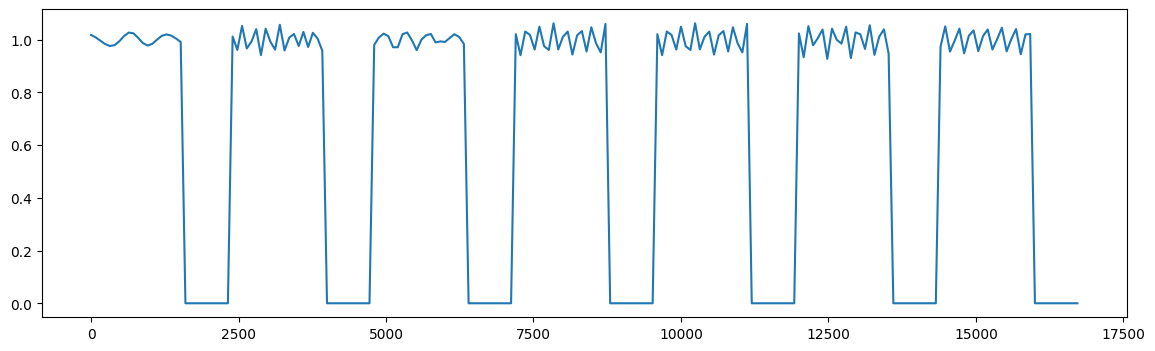

In [196]:
plt.plot(*local_power(x, 10));

From the plot it looks like a value of 0.5 for the threshold should do the trick. 

## Splitting the signal

The following function will return an array containing the start and stop indexes of each individual tone in the DTMF signal.

In [197]:
def DTMF_split(x: np.ndarray, threshold=0.5, chunk_len_ms=10, Fs=8000) -> list[tuple[int, int]]:
    ix, power = local_power(x, chunk_len_ms, Fs) # compute local energy over contiguous chunks
    tone_boundaries = [] 
    tone_start = 0
    # simple state machine to iterate through chunks, aternating between "silence" and "tone"
    state = 'silence'
    for n in range(0, len(power)):
        if state == 'silence':
            if power[n] > threshold:
                tone_start = ix[n] # transition from silence to tone: tone starting
                state = 'tone'
        elif state == 'tone':
            if power[n] < threshold: # energy dropped below threshold, tone ends and silence starts
                tone_boundaries.append( (tone_start, ix[n]) )
                state = 'silence'
    # this takes care of the last tone, if not followed by silence
    if state == 'tone':    
        tone_boundaries.append( (tone_start, len(x)) )
    return tone_boundaries

Let's check it out:

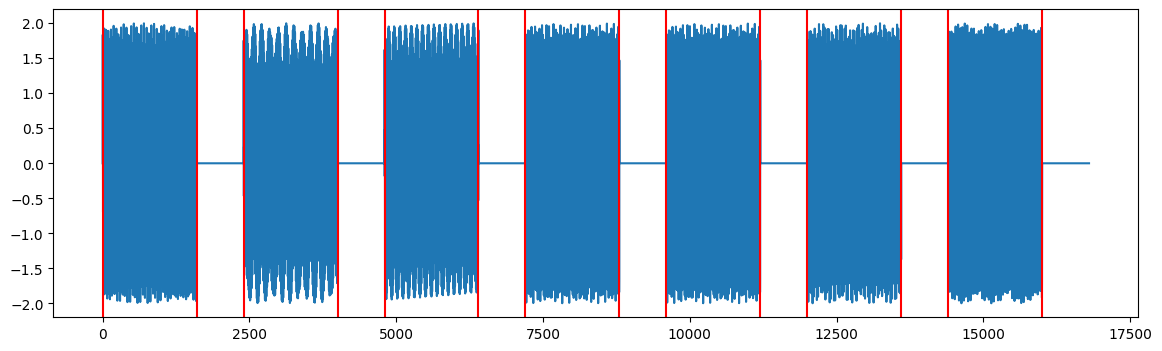

In [198]:
from itertools import chain
plt.plot(x);
for tone in chain.from_iterable(DTMF_split(x)):
    plt.axvline(tone, color='red')

## Frequency identification

<div style="text-align:center">
<img src="img/MatrixGIFFT.gif" width=500 height=500>
</div>

Now that we have a splitter, let's run a DFT over the tone sections and find the DTMF frequencies that are closest to the peaks of the DFT magnitude. 

The "low" DTMF frequencies are in the 697 Hz to 941 Hz range, while the high frequencies in the 1209 Hz to 1477 Hz range, so we will look for a DFT peak in each of those intervals. For instance, let's look at the first tone, and let's look at the peaks in the DFT:

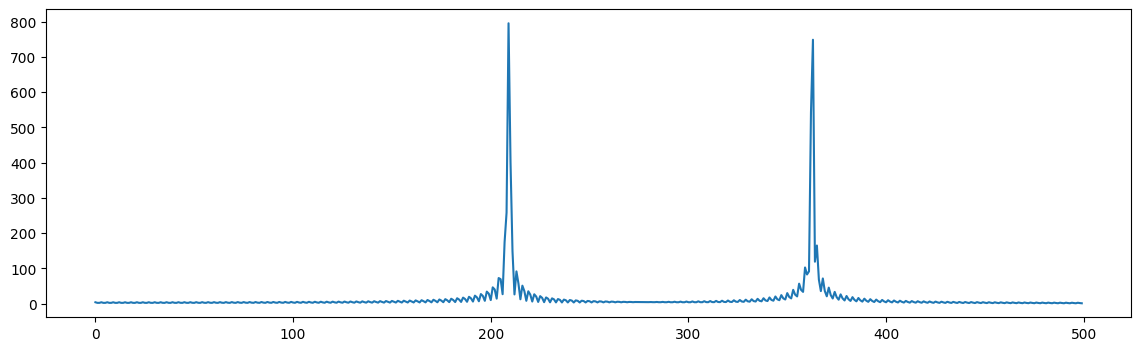

In [199]:
X = abs(np.fft.fft(x[0:2400]))
plt.plot(X[0:500]);

We clearly have identifiable peaks. The only thing we need to pay attention to is how to go from the DFT indexes to real-world frequencies and back. 

### Exercise: mapping hertz to DFT index (and vice-versa)

Complete the 2 functions below so that they perform the following tasks:
 - `Hz_to_DFT(frequencies, N, Fs)` takes a list of frequency values in hertz and returns the corresponding DFT indexes for a DFT of length `N` and sampling frequency `Fs` 
- `DFT_to_Hz(indexes, N, Fs)` takes a list of DFT indexes for a DFT of length `N` and returns the corresponding frequencies in hertz for a sampling frequency `Fs` 

In [200]:
def Hz_to_DFT(frequencies, N, Fs=8000):
    return np.round(np.array(frequencies)/Fs*N).astype(int)

def DFT_to_Hz(indexes, N, Fs=8000):
    return np.round(np.array(indexes)*Fs/N).astype(int)

Let's test your work:

In [201]:
f, k, N = (32, 24, 80), (4, 3, 10), 1000 
if np.sum(
    (Hz_to_DFT(f, N, Fs) - k) +   # Hz -> DFT correct
    (DFT_to_Hz(k, N, Fs) - f) +   # DFT -> Hz correct
    (Hz_to_DFT(DFT_to_Hz(k, N, Fs), N, Fs) - k)  # DFT -> Hz -> DFT correct
  ) == 0:
    print('good job')
else:
    print(t, 'sorry, try again...')

good job


### Exercise: find frequency peaks

Complete the function below so that it returns the frequency (in Hz) corresponding to the location of the largest spectral peak in the DFT of the data chunk for each of the ranges provided as an input

In [202]:
def find_frequency_peaks(
        data_chunk: np.ndarray, 
        ranges: list[tuple[float, float]], 
        Fs=8000,
) -> list[float]:
        peaks = []
        for fmin, fmax in ranges:
                # compute the DFT of the signal
                X = abs(np.fft.fft(data_chunk))
                # convert the frequency range to DFT indexes
                kmin, kmax = Hz_to_DFT([fmin, fmax], len(X), Fs)
                # find the index of the maximum value in the range
                k = np.argmax(X[kmin:kmax]) + kmin
                # convert the index back to frequency
                f = DFT_to_Hz(k, len(X), Fs)
                peaks.append(f)
        return peaks

Applying the function to the previous data chunk should return two frequency values that are close to or equal to the DTMF frequencies associated to key "1", that is, 697 Hz and 1209 Hz:

In [203]:
find_frequency_peaks(x[0:2400], [(697, 941), (1209, 1477)])

[697, 1210]

## The full decoder

Here is a full decoder for a DTMF signal, using all the building blocks developed previously:

In [204]:
def DTMF_decode(x: np.ndarray, threshold=0.5, chunk_len_ms=10, Fs=8000) -> list[str]:
    # rearrange DTMF data for decoding
    LO_FREQS = np.array([697.0, 770.0, 852.0, 941.0]) # DTMF rows
    HI_FREQS = np.array([1209.0, 1336.0, 1477.0])     # DTMF columns
    ranges = [ [np.min(freqs), np.max(freqs)] for freqs in [LO_FREQS, HI_FREQS] ]
    # DTMF matrix
    KEYS = [['1', '2', '3'], 
            ['4', '5', '6'], 
            ['7', '8', '9'], 
            ['*', '0', '#']] 
    
    number = []
    for tone_boundaries in DTMF_split(x, threshold, chunk_len_ms, Fs):
        f = find_frequency_peaks(x[slice(*tone_boundaries)], ranges, Fs)
        if len(f) != 2:
            print("input signal between n={tone[0]} and n={tone[1]} is not a valid DTMF tone")
        else:
            row = np.argmin(abs(LO_FREQS - f[0]))
            col = np.argmin(abs(HI_FREQS - f[1]))
            number.append(KEYS[row][col])
    return number            

In [205]:
DTMF_decode(x)

['1', '2', '3', '#', '#', '4', '5']

Yay! It works! As always, in communication systems, the receiver is often much more complicated than the sender. 

# Practical considerations

Obviously we used a very simplified setup and we have glossed over a lot of practical details. For instance, in the splitting function, the thresholds are not determined dynamically and this may create problems in the presence of noise. Similarly, we just detect a frequency peak in the spectrum, but noise may make things more complicated. 

For instance, listen to the following noise-corrupted version of the original signal. Although the tones are still detectable by ear, the segmentation algorithm fails and returns a single digit.

In [206]:
noisy = x + np.random.uniform(-2.5, 2.5, len(x))
IPython.display.Audio(noisy, rate=Fs)

In [207]:
DTMF_decode(noisy)

['3']

### Exercise: finding the decoding parameters

Use the `local_power()` function defined above to plot the per-chunk power of the noisy signal using increasingly longer chunk sizes (e.g. from 10ms to 60ms in 10ms increments). Look at the graph to determine what chunk size and what threshold value to pass to `DTMF_decode()` so that the noisy signal is correctly decoded.

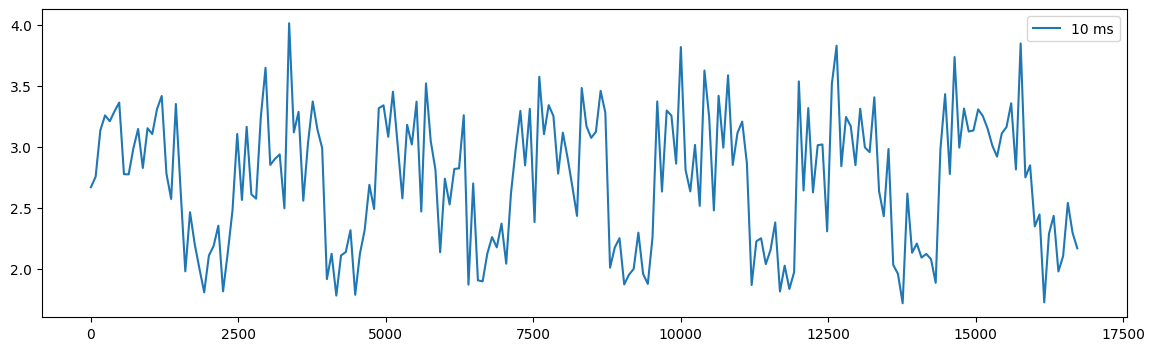

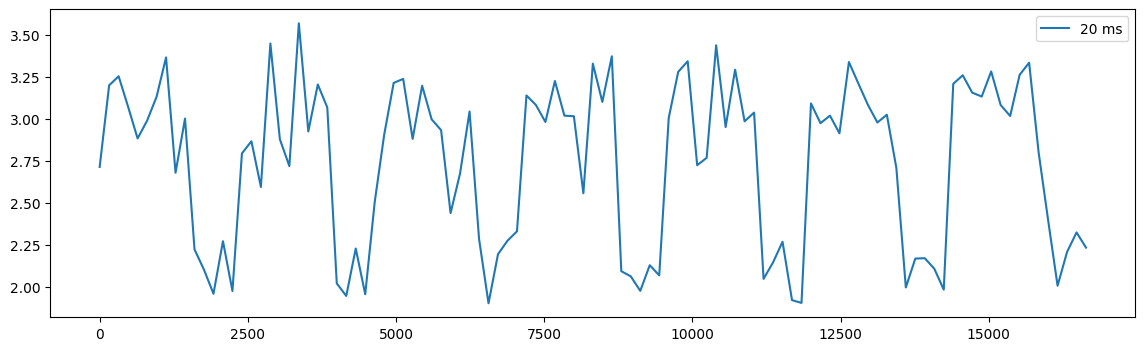

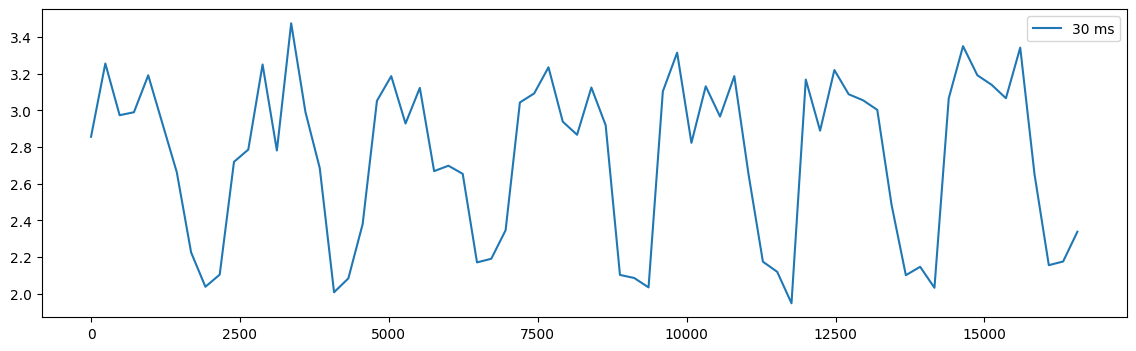

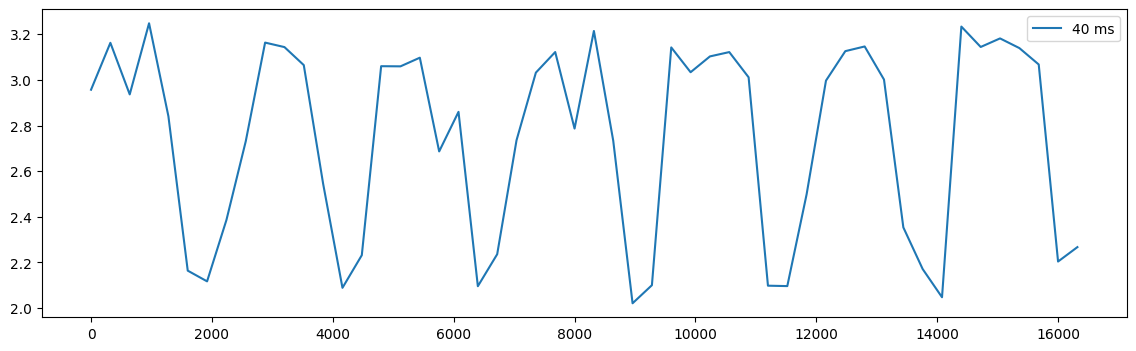

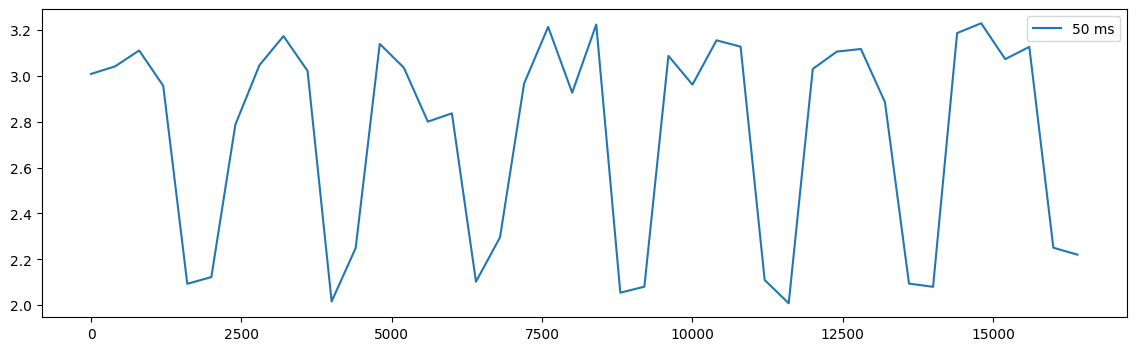

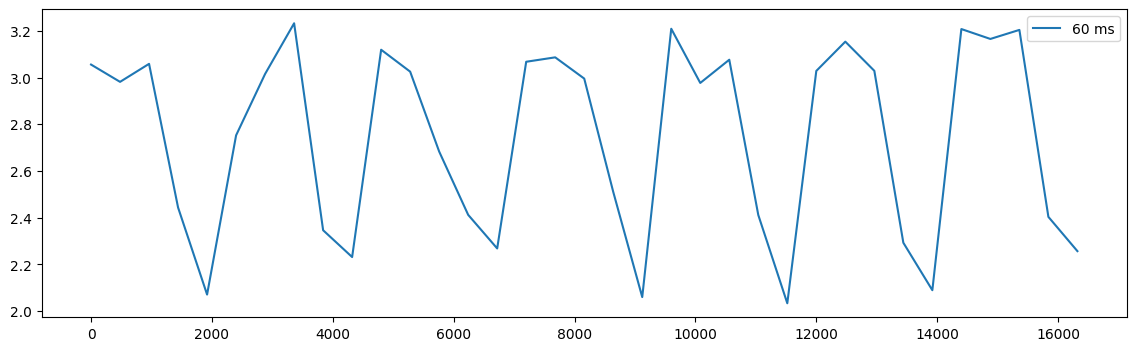

In [214]:
for chunk_len in range(10,70,10):
    plt.plot(*local_power(noisy, chunk_len));
    plt.legend([f'{chunk_len} ms'])
    plt.show()
    

In [227]:
DTMF_decode(noisy, chunk_len_ms=50,threshold=2.5)

['1', '2', '3', '#', '#', '4', '5']